In [9]:
# 12151411 심경수
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
from tqdm import tqdm
from sklearn.metrics import f1_score
warnings.filterwarnings("ignore")

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dropout, BatchNormalization, concatenate, MaxPooling2D
from sklearn.model_selection import train_test_split

In [10]:
# 데이터 로드
train_files = os.listdir('DACON/train')
test_files  = os.listdir('DACON/test')

# train 추출
train = []
for file in tqdm(train_files, desc = 'train'):
    try:
        data = np.load('DACON/train/' + file).astype('float32')
        valuable_data = data[:,:,-1].reshape(40, 40, 1)     #  읽은 데이터의 픽셀값을 확인하기 위한 처리
        if (valuable_data > 0).sum() >= 50 :               # 픽셀 값이 존재하느 셀이 50이상인 경우만 학습에 이용
            train.append(data)                              # 76345개의 데이터를 모두 사용하기에는 시간과 자원이 많이 필요
    except:
        continue
        
# test 추출
test = []
for file in tqdm(test_files, desc = 'test'):
    data = np.load('DACON/test/' + file).astype('float32')
    test.append(data)

# numpy array로 변환
train = np.array(train)
test  = np.array(test)

test: 100%|███████████████████████████████████████████████████████████████████████| 2416/2416 [00:14<00:00, 167.58it/s]


In [11]:
# 데이터의 속성값 확인
train_temp = train[:,:,:,:9]
train_ground = train[:,:,:,9]
train_GMI  = train[:,:,:,10:12]
train_DPR  = train[:,:,:,12:14]
train_rain = train[:,:,:,14]

test_temp = test[:,:,:,:9]
test_ground = test[:,:,:,9]
test_GMI = test[:,:,:,10:12]
test_DPR = test[:,:,:,12:14]

# 읽은 데이터 확인
print("train data ==============================")
print("temp_MAX : ", np.max(train_temp))
print("temp_Min : ", np.min(train_temp))
print("temp_NaN : ", np.isnan(train_temp).sum())

print("\nground_MAX : ", np.max(train_ground))
print("ground_MIN : ", np.min(train_ground))
print("ground_NaN : ", np.isnan(train_ground).sum())

print("\nGMI_MAX : ", np.max(train_GMI))
print("GMI_Min : ", np.min(train_GMI))
print("GMI_NaN : ", np.isnan(train_GMI).sum())

print("\nDPR_MAX : ", np.max(train_DPR))
print("DPR_Min : ", np.min(train_DPR))
print("DPR_NaN : ", np.isnan(train_DPR).sum())

print("\nrain_MAX : ", np.max(train_rain))
print("rain_Min : ", np.min(train_rain))
print("rain_NaN : ", np.isnan(train_rain).sum())

print("\n\ntest data ===============================")
print("temp_MAX : ", np.max(test_temp))
print("temp_Min : ", np.min(test_temp))
print("temp_NaN : ", np.isnan(test_temp).sum())

print("\nground_MAX : ", np.max(test_ground))
print("ground_MIN : ", np.min(test_ground))
print("ground_NaN : ", np.isnan(test_ground).sum())

print("\nGMI_MAX : ", np.max(test_GMI))
print("GMI_Min : ", np.min(test_GMI))
print("GMI_NaN : ", np.isnan(test_GMI).sum())

print("\nDPR_MAX : ", np.max(test_DPR))
print("DPR_Min : ", np.min(test_DPR))
print("DPR_NaN : ", np.isnan(test_DPR).sum())

train data ==============================
temp_MAX :  1509.0977
temp_Min :  45.827557
temp_NaN :  0

ground_MAX :  322.0
ground_MIN :  0.0
ground_NaN :  0

GMI_MAX :  176.28397
GMI_Min :  4.4489517
GMI_NaN :  0

DPR_MAX :  176.28854
DPR_Min :  4.493651
DPR_NaN :  0

rain_MAX :  299.9978
rain_Min :  -9999.9
rain_NaN :  0


test data ===============================
temp_MAX :  1576.5103
temp_Min :  79.81796
temp_NaN :  0

ground_MAX :  322.0
ground_MIN :  0.0
ground_NaN :  0

GMI_MAX :  176.32259
GMI_Min :  4.450847
GMI_NaN :  0

DPR_MAX :  176.31268
DPR_Min :  4.494995
DPR_NaN :  0


In [12]:
# 부적절한 강수량 데이터 확인
np.where(train_rain < 0)

(array([  980,   980,   980, ..., 29330, 29330, 29330], dtype=int64),
 array([ 0,  0,  0, ..., 32, 32, 32], dtype=int64),
 array([ 0,  1,  2, ...,  5, 38, 39], dtype=int64))

In [13]:
# 학습 데이터 선택
# 온도 채널 (0~9), 지표면 정보(9), GMI 경도, 위도(10, 11), DPR 경도, 위도 (12, 13)
# Class : 강수량 (14)
x_train = train[:,:,:,:14]  
y_train = train[:,:,:,14]   # 강수량

# del train
x_train.shape, y_train.shape

((30760, 40, 40, 14), (30760, 40, 40))

In [14]:
# 음수 데이터 삭제
# y_train ==> ( [index], [y축], [x축])
rain_data = y_train.reshape(-1,y_train.shape[1] * y_train.shape[2])   

# 강수량 정보에 음수가 포함되어 있으면 해당 인덱스 제거
x_train = np.delete(x_train, np.where(rain_data<0)[0], axis=0)
y_train = np.delete(y_train, np.where(rain_data<0)[0], axis=0)

# Class 형태 재조정
y_train = y_train.reshape(-1, x_train.shape[1], x_train.shape[2],1)

x_train.shape, y_train.shape

((30728, 40, 40, 14), (30728, 40, 40, 1))

In [15]:
# 부적절한 강수량 데이터 제거 확인
np.where(y_train < 0)

(array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64))

In [16]:
# 모델 학습용 training, test 데이터 분류
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size = 0.025, random_state = 7777)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((29959, 40, 40, 14), (29959, 40, 40, 1), (769, 40, 40, 14), (769, 40, 40, 1))

In [17]:
# 평가 지표
'''
평가 지표는 MAE를 F1 score로 나눈 값입니다.
이 때 MAE는 실제 값이 0.1 이상인 픽셀에 대해서만 산출하며, 
F1 score는 해당 픽셀의 강수량이 0.1 이상이면 1, 0.1 미만이면 0으로 변환 후 1에 대해 F1 score를 산출합니다.
실제 값에 결측치(-9999.xxx)가 포함된 경우, 결측치가 포함된 픽셀은 F1 score 계산에서 제외 합니다. 
'''
# 평가함수 정의
# 평가함수 : MAE over Fscore 정의
# DACON 대회 규칙에 있는 내용 사용
def mae_over_fscore(y_true, y_pred) :
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    y_true = y_true.reshape(1, -1)[0]
    y_pred = y_pred.reshape(1, -1)[0]
    
    # 확인 대상 - 0.1 이상인 픽셀의 위치 확인
    IsGreaterThanEqualTo_PointOne = y_true >= 0.1
    
    # 결측값이 없는 픽셀의 위치 확인
    IsNotMissing  = y_true >= 0
    
    # mae 계산
    mae = np.mean(np.abs(y_true[IsNotMissing ] - y_true[IsGreaterThanEqualTo_PointOne ]))
    
    # f1_score 계산 위해, 실제값에 결측값이 없는 픽셀에 대해 1과 0으로 값 변환
    y_true = np.where(y_true[IsNotMissing] >= 0.1, 1, 0)
    y_pred = np.where(y_pred[IsNotMissing] >= 0.1, 1, 0)
    
    fscore = f1_score(y_true, y_pred)
    
    return mae / (fscore + 1e-07)

# 손실함수 정의
# DACON의 baseline에서 정의한 손실함수 인용
# 손실함수 : MAE 정의
def mae(y_true, y_pred) :
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    y_true = y_true.reshape(1, -1)[0]
    y_pred = y_pred.reshape(1, -1)[0]
    
    over_threshold = y_true >= 0.1
    return np.mean(np.abs(y_true[over_threshold] - y_pred[over_threshold]))

# 손실함수 : Fscore 정의
def fscore(y_true, y_pred) :
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    y_true = y_true.reshape(1, -1)[0]
    y_pred = y_pred.reshape(1, -1)[0]
    
    remove_NAs = y_true >= 0
    y_true = np.where(y_true[remove_NAs] >= 0.1, 1, 0)
    y_pred = np.where(y_pred[remove_NAs] >= 0.1, 1, 0)
    return f1_score(y_true, y_pred)

# 손실함수 : MAE over Fscore 정의
def maeOverFscore(y_true, y_pred) :
    return mae(y_true, y_pred) / (fscore(y_true, y_pred) + 1e-07)

# 손실함수 : keras 용 fscore 정의
def fscore_keras(y_true, y_pred):
    score = tf.py_function(func = fscore, inp = [y_true, y_pred],
                           Tout = tf.float32, name = 'fscore_keras')
    return score

# 점수 (텐서플로우 자료형을 사용하지 않은 경우 발생하는 오류로 인해 사용)
def score(y_true, y_pred) :
    score = tf.py_function(func = maeOverFscore, inp = [y_true, y_pred], 
                          Tout = tf.float32, name = 'custom_mse')
    return score

In [18]:
# 모델 설계부분
def CNN_create(train_data) :
    # input data to model
    Input_layer = Input(train_data.shape[1:])
    Batch = BatchNormalization()(Input_layer)          # 데이터 정규화 계층

    # Hidden Layer of CNN
    Conv0 = Conv2D(256, kernel_size = 1, strides = 1, padding = 'same', activation = 'relu')(Batch)
    Batch = BatchNormalization()(Conv0)             # 데이터 정규화 계층
    Drop  = Dropout(0.2)(Batch)                     # 과적합(Overfitting) 예방을 위해 임의의 20% 노드 비활성화
    
    Conv1 = Conv2D(128, kernel_size = 2, strides = 1, padding = 'same', activation = 'relu')(Drop)
    Batch = BatchNormalization()(Conv1)             # 데이터 정규화 계층                
    Conc  = concatenate([Drop, Batch], axis = 3)    # 계층 이어붙이기
    Drop  = Dropout(0.2)(Batch)                     # 과적합(Overfitting) 예방을 위해 임의의 20% 노드 비활성화
    
    Conv2 = Conv2D(64, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu')(Drop)
    Batch = BatchNormalization()(Conv2)             # 데이터 정규화 계층
    Conc  = concatenate([Drop, Batch], axis = 3)    # 계층 이어붇이기
    Drop  = Dropout(0.2)(Batch)                     # 과적합(Overfitting) 예방을 위해 임의의 20% 노드 비활성화
    
    Conv3 = Conv2D(32, kernel_size = 2, strides = 1, padding = 'same', activation = 'relu')(Drop)
    Batch = BatchNormalization()(Conv3)             # 데이터 정규화 계층
    Conc  = concatenate([Drop, Batch], axis = 3)    # 계층 이어붇이기
    Drop  = Dropout(0.2)(Batch)                     # 과적합(Overfitting) 예방을 위해 임의의 20% 노드 비활성화
    
    # Output Layer
    Batch = BatchNormalization()(Drop)
    Output_layer = Conv2D(1, kernel_size = 1, strides = 1, padding = 'same', activation = 'relu')(Batch)

    return Model(inputs = Input_layer, outputs = Output_layer)

In [35]:
# 모델 생성
CNN = CNN_create(x_train)
CNN.compile(loss = 'mae', optimizer = 'adam', metrics = [score, fscore_keras])
# CNN.summary()                  # 모델 정보 요약

# 모델 학습 진행
history = CNN.fit(x_train, y_train, epochs = 20, batch_size = 128, validation_data = (x_test, y_test))

Epoch 1/20


KeyboardInterrupt: 

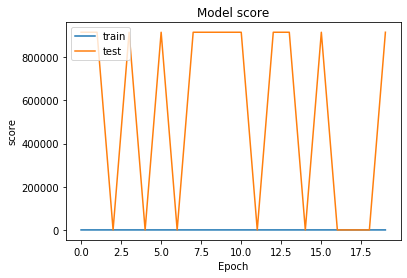

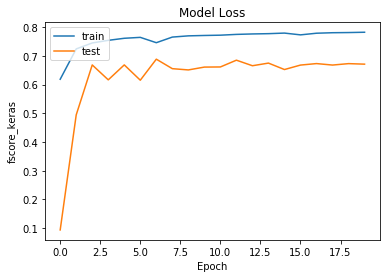

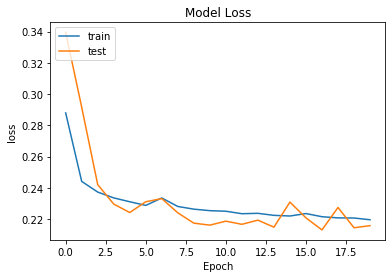

In [20]:
# score 시각화
plt.plot(history.history['score'])
plt.plot(history.history['val_score'])
plt.title('Model score')
plt.xlabel('Epoch')
plt.ylabel('score')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

# fscore_keras 시각화
plt.plot(history.history['fscore_keras'])
plt.plot(history.history['val_fscore_keras'])
plt.title('Model fscore')
plt.xlabel('Epoch')
plt.ylabel('fscore_keras')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

# Loss 시각화
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

In [28]:
# train 데이터 저장
np.save('DACON/x_train_save.npy', x_train)
np.save('DACON/y_train_save.npy', y_train)
np.save('DACON/x_test_save.npy', x_test)
np.save('DACON/y_test_save.npy', y_test)

# test 데이터 저장
np.save('DACON/test1_save.npy', test1)

# train, test 데이터 불러오기
# newtrain = np.load('DACON/train_save.npy')
# newtest = np.load('DACON/test_save.npy')

In [33]:
# 학습에 사용하지 않은 데이터로 평가하기
evalu = CNN.evaluate(x_test, y_test)

print("\nloss(MAE)\t\t: %.4f" % evalu[0])
print("score(maeOverFscore)\t: %.4f " % evalu[1])
print("fscore_keras\t\t: %.4f" % evalu[2])

25/25 [==============================] - 3s 132ms/step - loss: 0.2182 - score: 1.8163 - fscore_keras: 0.7412

loss(MAE)		: 0.2182
score(maeOverFscore)	: 1.8163 
fscore_keras		: 0.7412


In [34]:
# 제출 부분
predicts = CNN.predict(test)

submission = pd.read_csv('DACON/sample_submission.csv')
submission.iloc[:, 1:] = predicts.reshape(-1, 1600)
# submission.to_csv('DACON/Dacon_predict_test_without_GMI,DPR.csv', index = False)
submission.to_csv('DACON/Dacon_predict_test_with_GMI,DPR.csv', index = False)